# Hello World Unet

The code is heavily inspired on https://github.com/zhixuhao/unet

The data is ISBI dataset, as used by zhixuhao, with minor folder restructuring

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import skimage.io as skimage_io
import skimage.transform as skimage_transform
import random as r
import numpy as np
import datetime
import tensorflow as tf
import tensorflow.keras as tf_keras


print("Tensorflow {}".format(tf.__version__))
print("GPU devices: {}".format(tf.config.list_physical_devices('GPU')))

Tensorflow 2.6.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Setup options

In [2]:
datasetPath = "../membrane"
trainFolder = "train"
valFolder = "aug-val"
testFolder = "test"
modelsPath = "models"


trainSize = -1 # -1 for all
valSize = -1 # -1 for all
testSize = -1 # -1 for all
exampleSize = (512, 512)
inputSize = (256, 256)
maskSize = (256, 256)
batchSize = 4
epochs = 20
learning_rate = 1e-4
numClasses = 2
showImages = True

modelFileName = "unet_membrane_TCV" + "E" + str(epochs) + "LR" + str(learning_rate) + ".hdf5"
resultsPath = "membrane/test/predict" + "E" + str(epochs) + "LR" + str(learning_rate)

augmentation_args = dict(
    width_shift_range=range(256),
    height_shift_range=range(256),
    rotation_range=[0, 90, 180, 270],
    horizontal_flip=True,
    vertical_flip=True
)

r.seed(1)

## Train/test split

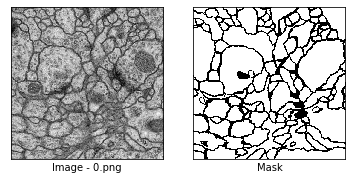

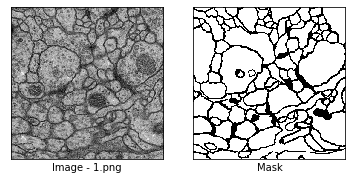

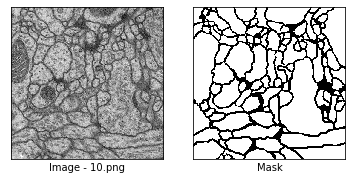

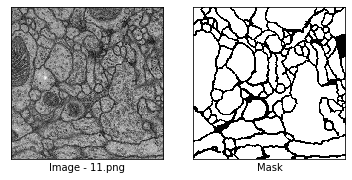

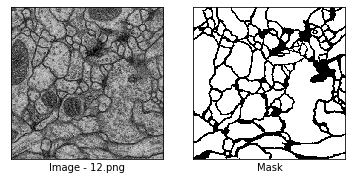

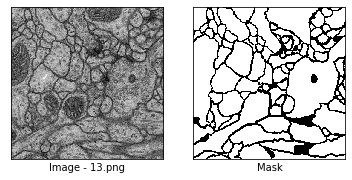

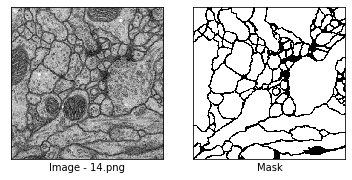

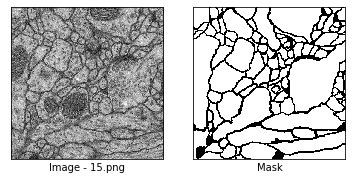

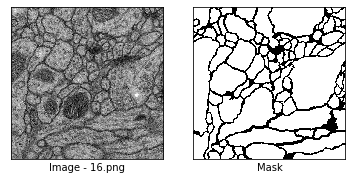

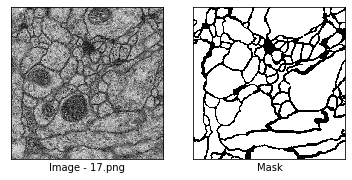

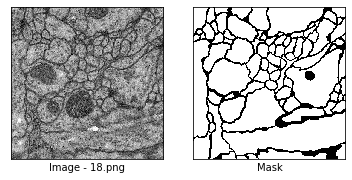

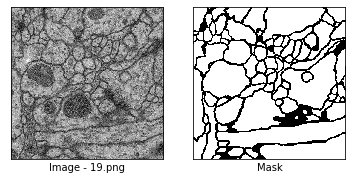

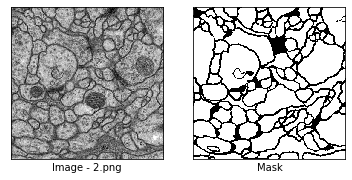

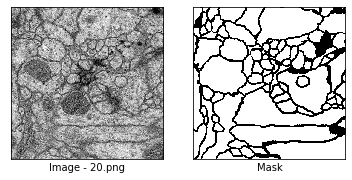

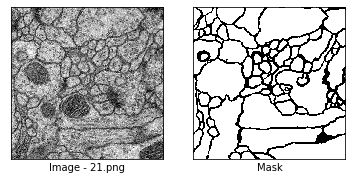

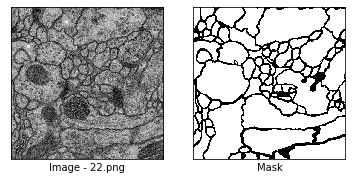

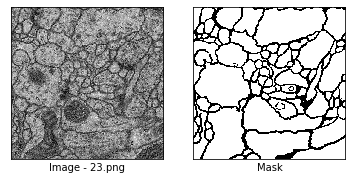

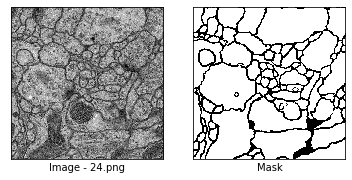

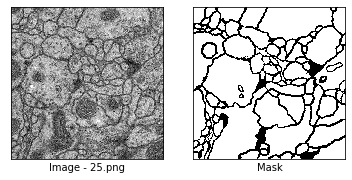

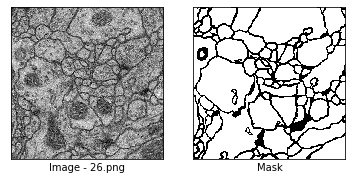

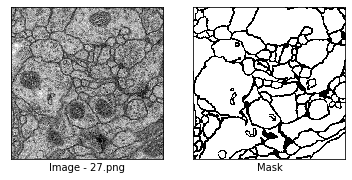

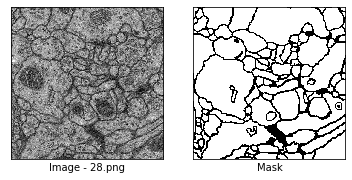

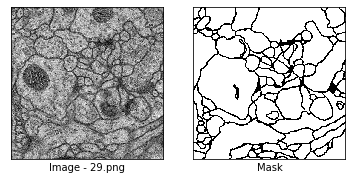

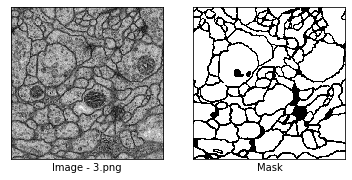

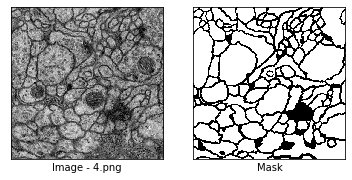

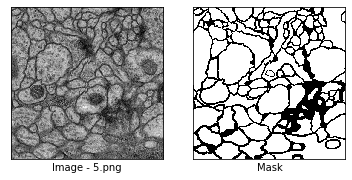

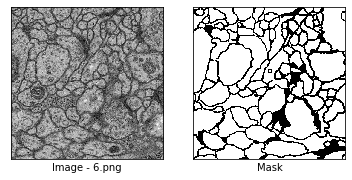

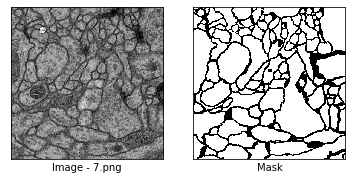

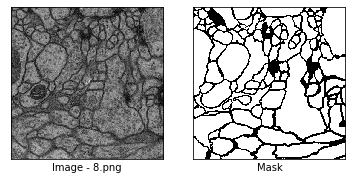

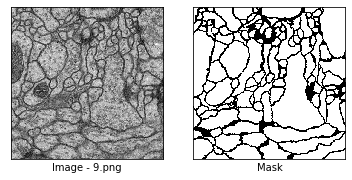

In [3]:
def prepareDataset(datasetPath, trainFolder, valFolder, testFolder):
    trainSetX = []
    trainSetY = []
    valSetX = []
    valSetY = []
    testSetX = []

    trainImagesPath = os.path.join(datasetPath, trainFolder, "image")
    trainMasksPath = os.path.join(datasetPath, trainFolder, "label")
    trainSetFolder = os.scandir(trainImagesPath)

    for tile in trainSetFolder:
        imagePath = tile.path
        trainSetX.append(imagePath)
        if (showImages):
            image =  skimage_io.imread(imagePath)
            maskPath = os.path.join(trainMasksPath, os.path.basename(imagePath))
            mask = skimage_io.imread(maskPath)
            plt.figure(figsize=(6, 3))
            plt.subplot(1, 2, 1)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(image, cmap='gray')
            plt.xlabel("Image - {}".format(os.path.basename(imagePath)))
            plt.subplot(1, 2, 2)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mask, cmap='gray')
            plt.xlabel("Mask")
            plt.show()

    r.shuffle(trainSetX)
    for trainExample in trainSetX:
        maskPath = os.path.join(trainMasksPath, os.path.basename(trainExample))
        trainSetY.append(maskPath)

    valImagesPath = os.path.join(datasetPath, valFolder, "image")
    valSetXFolder = os.scandir(valImagesPath)
    for tile in valSetXFolder:
        imagePath = tile.path
        valSetX.append(imagePath)
    valMasksPath = os.path.join(datasetPath, valFolder, "label")
    valSetYFolder = os.scandir(valMasksPath)
    for tile in valSetYFolder:
        maskPath = tile.path
        valSetY.append(maskPath)

    testImagesPath = os.path.join(datasetPath, testFolder, "image")
    testSetFolder = os.scandir(testImagesPath)
    for tile in testSetFolder:
        imagePath = tile.path
        testSetX.append(imagePath)

    return trainSetX, trainSetY, valSetX, valSetY, testSetX

trainSetX, trainSetY, valSetX, valSetY, testSetX = prepareDataset(
    datasetPath=datasetPath, 
    trainFolder=trainFolder, 
    valFolder=valFolder, 
    testFolder=testFolder)

if trainSize > 0:
    trainSetX = trainSetX[0:trainSize]
    trainSetY = trainSetY[0:trainSize]
if valSize > 0:
    valSetX = valSetX[0:valSize]
    valSetY = valSetY[0:valSize]
if testSize > 0:
    testSetX = testSetX[0:testSize]

## Data Loaders

In [4]:
def normalizeMask(mask, num_class=2):
    mask = mask/255
    new_mask = np.zeros(mask.shape + (num_class,))
    for i in range(num_class):
        new_mask[mask == i, i] = 1.
    return new_mask


def normalizeChannel(channel):
    return (channel - 128.0) / 128.0


def getImageChannels(tile):
    channel0 = skimage_io.imread(tile, as_gray=True)
    channel0 = normalizeChannel(channel0)
    return [channel0]


def augmentImage(image, inputSize, mask, maskSize, aug_dict):
    if 'width_shift_range' in aug_dict:
        cropx = r.sample(aug_dict['width_shift_range'], 1)[0]
    else:
        cropx = (int)((image[0].shape[1] - inputSize[1]) / 2)
    if 'height_shift_range' in aug_dict:
        cropy = r.sample(aug_dict['height_shift_range'], 1)[0]
    else:
        cropy = (int)((image[0].shape[0] - inputSize[0]) / 2)
    if 'rotation_range' in aug_dict:
        rotation = r.sample(aug_dict['rotation_range'], 1)[0]
    else:
        rotation = 0
    if 'horizontal_flip' in aug_dict and aug_dict['horizontal_flip']:
        do_horizontal_flip = r.sample([False,True], 1)[0]
    else:
        do_horizontal_flip = False
    if 'vertical_flip' in aug_dict and aug_dict['vertical_flip']:
        do_vertical_flip = r.sample([False, True], 1)[0]
    else:
        do_vertical_flip = False

    maskOffsety = int((inputSize[0]-maskSize[0])/2)
    maskOffsetx = int((inputSize[1]-maskSize[1])/2)
    mask = mask[maskOffsety+cropy:maskOffsety+cropy+maskSize[0], maskOffsetx+cropx:maskOffsetx+cropx+maskSize[1]]
    if rotation:
        mask = skimage_transform.rotate(mask, rotation)
    if do_horizontal_flip:
        mask = mask[:, ::-1]
    if do_vertical_flip:
        mask = mask[::-1, :]

    for i in range(len(image)):
        channel = image[i]
        channel = channel[cropy:cropy+inputSize[0], cropx:cropx+inputSize[1]]
        if rotation:
            channel = skimage_transform.rotate(channel, rotation)
        if do_horizontal_flip:
            channel = channel[:, ::-1]
        if do_vertical_flip:
            channel = channel[::-1, :]
        image[i] = channel
    return image, mask


def trainGenerator(batch_size, trainSetX, trainSetY, aug_dict, inputSize=(256, 256), inputChannels=1, maskSize=(256, 256), numClasses=2):
    if batch_size > 0:
        while 1:
            iTile = 0
            nBatches = int(np.ceil(len(trainSetX)/batch_size))
            for batchID in range(nBatches):
                images = np.zeros(((batch_size,) + inputSize + (inputChannels,))) # 1 channel
                masks = np.zeros(((batch_size,) + maskSize + (numClasses,)))
                iTileInBatch = 0
                while iTileInBatch<batch_size:
                    if iTile < len(trainSetX):
                        # print(iTile, "/", len(trainSetX), ";", iTileInBatch, "/", batch_size, ";", trainSetX[iTile], trainSetY[iTile])

                        image = getImageChannels(trainSetX[iTile])
                        mask = skimage_io.imread(trainSetY[iTile], as_gray=True)
                        mask = normalizeMask(mask)
                        image, mask = augmentImage(image, inputSize, mask, maskSize, aug_dict)
                        for i in range(len(image)):
                            images[iTileInBatch, :, :, i] = image[i]
                        masks[iTileInBatch, :, :, :] = mask

                        iTile = iTile + 1
                        iTileInBatch = iTileInBatch + 1
                    else:
                        images = images[0:iTileInBatch,:,:,:]
                        masks = masks[0:iTileInBatch,:,:,:]
                        break
                yield (images, masks)

def do_center_crop(image, newSize):
    cropy = (int)((image[0].shape[0] - newSize[0]) / 2)
    cropx = (int)((image[0].shape[1] - newSize[1]) / 2)
    for i in range(len(image)):
        channel = image[i]
        channel = channel[cropy:image[0].shape[0] - cropy, cropx:image[0].shape[1] - cropx]
        image[i] = channel

    return image


def testGenerator(testSetX, inputSize=(256, 256), inputChannels=1):
    for tile in testSetX:
        image = getImageChannels(tile)
        image = do_center_crop(image, inputSize)
        img = np.zeros(inputSize + (inputChannels,))
        for i in range(len(image)):
            img[:, :, i] = image[i]

        img = np.array([img])
        yield (img)


trainGene = trainGenerator(batchSize, 
                           trainSetX, 
                           trainSetY,
                           augmentation_args, 
                           inputSize=inputSize,
                           inputChannels=1,
                           maskSize=maskSize,
                           numClasses=numClasses)
valGene = trainGenerator(batchSize, 
                         valSetX, 
                         valSetY,
                         dict(), 
                         inputSize=inputSize,
                         inputChannels=1,
                         maskSize=maskSize,
                         numClasses=numClasses)

## Define Unet Model

In [5]:
def unetCustom(pretrained_weights=None, inputSize=(256, 256, 1), numClass=2, do_batch_normalization=False, use_transpose_convolution=False):
    inputs = tf.keras.layers.Input(inputSize)
    conv1 = tf.keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    if do_batch_normalization:
        conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation('relu')(conv1)
    conv1 = tf.keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    if do_batch_normalization:
        conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation('relu')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    if do_batch_normalization:
        conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Activation('relu')(conv2)
    conv2 = tf.keras.layers.Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    if do_batch_normalization:
        conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Activation('relu')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    if do_batch_normalization:
        conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Activation('relu')(conv3)
    conv3 = tf.keras.layers.Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    if do_batch_normalization:
        conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Activation('relu')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    if do_batch_normalization:
        conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Activation('relu')(conv4)
    conv4 = tf.keras.layers.Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    if do_batch_normalization:
        conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Activation('relu')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    if do_batch_normalization:
        conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Activation('relu')(conv5)
    conv5 = tf.keras.layers.Conv2D(1024, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    if do_batch_normalization:
        conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Activation('relu')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    if use_transpose_convolution:
        up6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2))(drop5)
    else:
        up6 = tf.keras.layers.Conv2D(512, 2, padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    if do_batch_normalization:
        up6 = tf.keras.layers.BatchNormalization()(up6)
    up6 = tf.keras.layers.Activation('relu')(up6)
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    if do_batch_normalization:
        conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = tf.keras.layers.Activation('relu')(conv6)
    conv6 = tf.keras.layers.Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    if do_batch_normalization:
        conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = tf.keras.layers.Activation('relu')(conv6)

    if use_transpose_convolution:
        up7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2))(conv6)
    else:
        up7 = tf.keras.layers.Conv2D(256, 2, padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    if do_batch_normalization:
        up7 = tf.keras.layers.BatchNormalization()(up7)
    up7 = tf.keras.layers.Activation('relu')(up7)
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    if do_batch_normalization:
        conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = tf.keras.layers.Activation('relu')(conv7)
    conv7 = tf.keras.layers.Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    if do_batch_normalization:
        conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = tf.keras.layers.Activation('relu')(conv7)

    if use_transpose_convolution:
        up8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2))(conv7)
    else:
        up8 = tf.keras.layers.Conv2D(128, 2, padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    if do_batch_normalization:
        up8 = tf.keras.layers.BatchNormalization()(up8)
    up8 = tf.keras.layers.Activation('relu')(up8)
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    if do_batch_normalization:
        conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = tf.keras.layers.Activation('relu')(conv8)
    conv8 = tf.keras.layers.Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    if do_batch_normalization:
        conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = tf.keras.layers.Activation('relu')(conv8)

    if use_transpose_convolution:
        up9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2))(conv8)
    else:
        up9 = tf.keras.layers.Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    if do_batch_normalization:
        up9 = tf.keras.layers.BatchNormalization()(up9)
    up9 = tf.keras.layers.Activation('relu')(up9)
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    if do_batch_normalization:
        conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = tf.keras.layers.Activation('relu')(conv9)
    conv9 = tf.keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    if do_batch_normalization:
        conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = tf.keras.layers.Activation('relu')(conv9)
    conv10 = tf.keras.layers.Conv2D(numClass, 1, activation='softmax', kernel_initializer ='he_normal')(conv9)

    model = tf.keras.models.Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


## Instantiate a model

In [6]:
model = unetCustom(inputSize=(256, 256, 1), numClass=2, do_batch_normalization=False, use_transpose_convolution=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

## Create callbacks

In [7]:
class BatchLossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []
        self.batch_accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))
        self.batch_accuracies.append(logs.get('accuracy'))


batch_history = BatchLossHistory()

modelFilePath = os.path.join(modelsPath, modelFileName)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelFilePath, monitor='val_loss', verbose=1, save_best_only=True)

log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Train the model

In [8]:
Ntrain = len(trainSetX)
stepsPerEpoch = np.ceil(Ntrain / batchSize)
Nval = len(valSetX)
validationSteps = np.ceil(Nval / batchSize)

history = model.fit(trainGene,
                    steps_per_epoch=stepsPerEpoch,
                    epochs=epochs,
                    callbacks=[model_checkpoint,
                               batch_history,
                               tensorboard_callback,
                               ],
                    validation_data=valGene,
                    validation_steps=validationSteps)

Epoch 1/20
8/8 [==============================] - 31s 2s/step - loss: 0.6581 - accuracy: 0.6565 - val_loss: 0.4884 - val_accuracy: 0.7822

Epoch 00001: val_loss improved from inf to 0.48842, saving model to models\unet_membrane_TCVE20LR0.0001.hdf5
Epoch 2/20
8/8 [==============================] - 9s 1s/step - loss: 0.4599 - accuracy: 0.7849 - val_loss: 0.4343 - val_accuracy: 0.7830

Epoch 00002: val_loss improved from 0.48842 to 0.43429, saving model to models\unet_membrane_TCVE20LR0.0001.hdf5
Epoch 3/20
8/8 [==============================] - 9s 1s/step - loss: 0.4002 - accuracy: 0.7939 - val_loss: 0.3997 - val_accuracy: 0.7877

Epoch 00003: val_loss improved from 0.43429 to 0.39967, saving model to models\unet_membrane_TCVE20LR0.0001.hdf5
Epoch 4/20
8/8 [==============================] - 9s 1s/step - loss: 0.3628 - accuracy: 0.8260 - val_loss: 0.4045 - val_accuracy: 0.7880

Epoch 00004: val_loss did not improve from 0.39967
Epoch 5/20
8/8 [==============================] - 9s 1s/step 

## Plot trainning curves

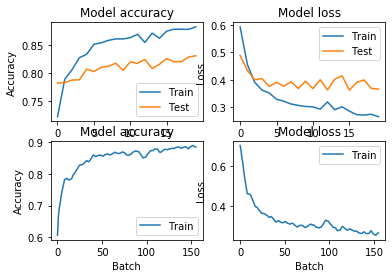

In [9]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.subplot(2, 2, 3)
plt.plot(moving_average(batch_history.batch_accuracies, 5))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.legend(['Train'], loc='lower right')

# Plot training & validation loss values
plt.subplot(2, 2, 4)
plt.plot(moving_average(batch_history.batch_losses, 5))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.legend(['Train'], loc='upper right')

#plt.show()

## Use the model to predict

In [10]:
testGene = testGenerator(testSetX, inputSize=inputSize, inputChannels=1)
NTest=len(testSetX)
testSteps = np.ceil(NTest / batchSize)
results = model.predict(testGene, verbose=1)

30/30 [==============================] - 5s 71ms/step


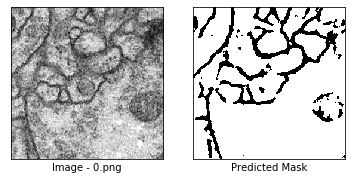

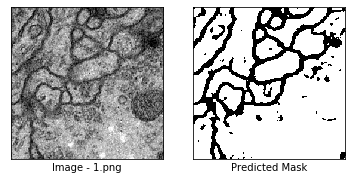

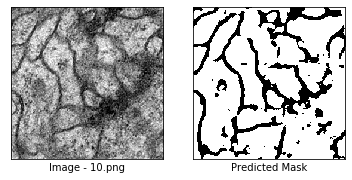

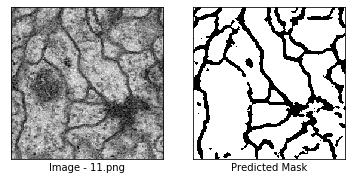

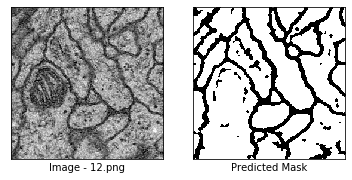

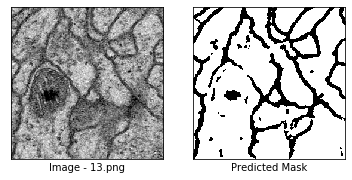

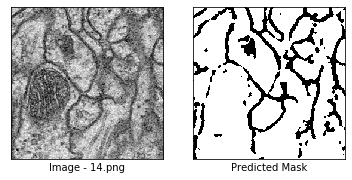

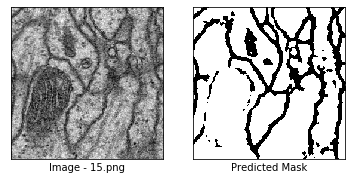

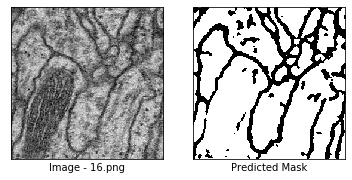

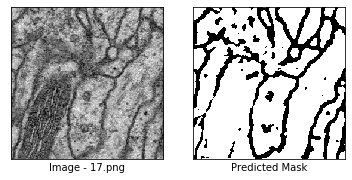

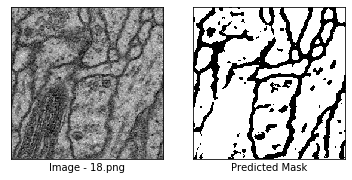

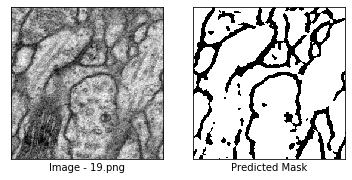

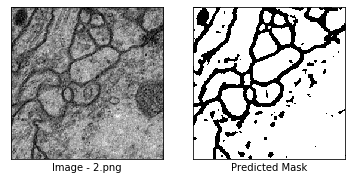

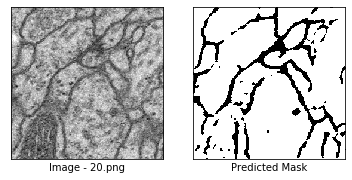

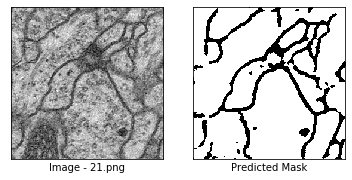

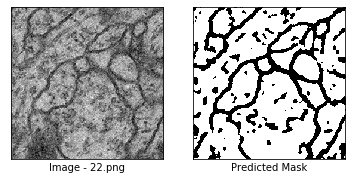

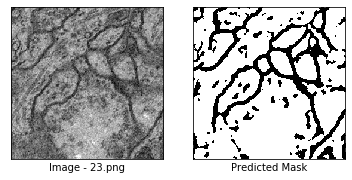

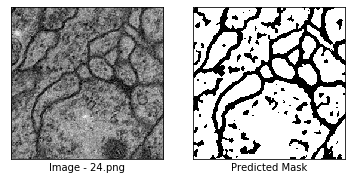

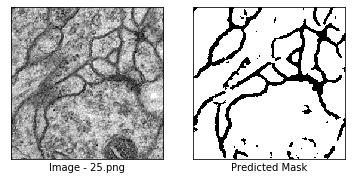

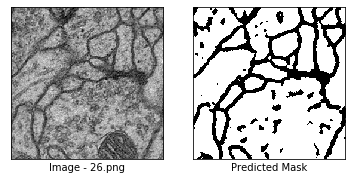

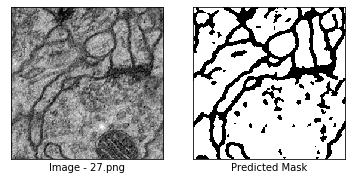

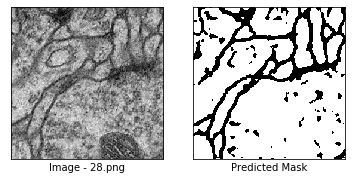

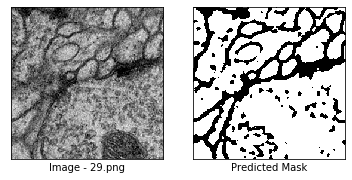

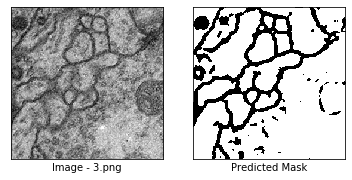

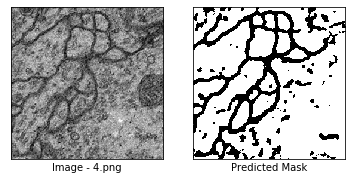

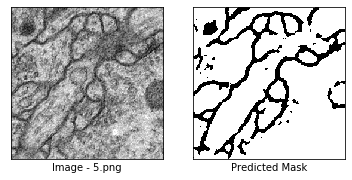

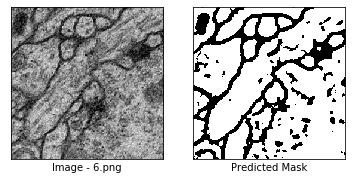

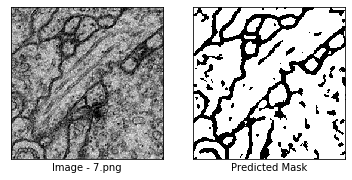

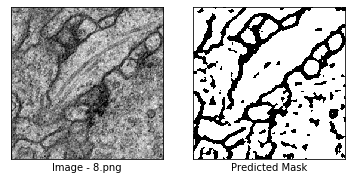

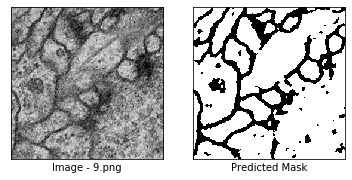

In [11]:
def do_center_crop_channel(image, newSize):
    cropy = (int)((image.shape[0] - newSize[0]) / 2)
    cropx = (int)((image.shape[1] - newSize[1]) / 2)
    return image[cropy:image.shape[0] - cropy, cropx:image.shape[1] - cropx]

def saveResults(testSetX, results, resultsPath):
    for i,item in enumerate(results):
        filename = testSetX[i]
        mask_predict = np.argmax(item, axis=-1)
        mask_predict = mask_predict.astype(np.uint8)
        mask_predict = mask_predict * 255
        skimage_io.imsave(os.path.join(resultsPath, os.path.basename(filename) + "_predict.png"), mask_predict)
        if (showImages):
            imagePath = filename
            image =  skimage_io.imread(imagePath)
            image = do_center_crop_channel(image, newSize=(256, 256))
    
            plt.figure(figsize=(6, 3))
            plt.subplot(1, 2, 1)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(image, cmap='gray')
            plt.xlabel("Image - {}".format(os.path.basename(imagePath)))
            plt.subplot(1, 2, 2)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mask_predict, cmap='gray')
            plt.xlabel("Predicted Mask")
            plt.show()


        
if not os.path.exists(resultsPath):
    os.makedirs(resultsPath)

saveResults(testSetX, results, resultsPath)